<a href="https://colab.research.google.com/github/moonlitknight/Sonoff-Tasmota/blob/master/AI_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Approach
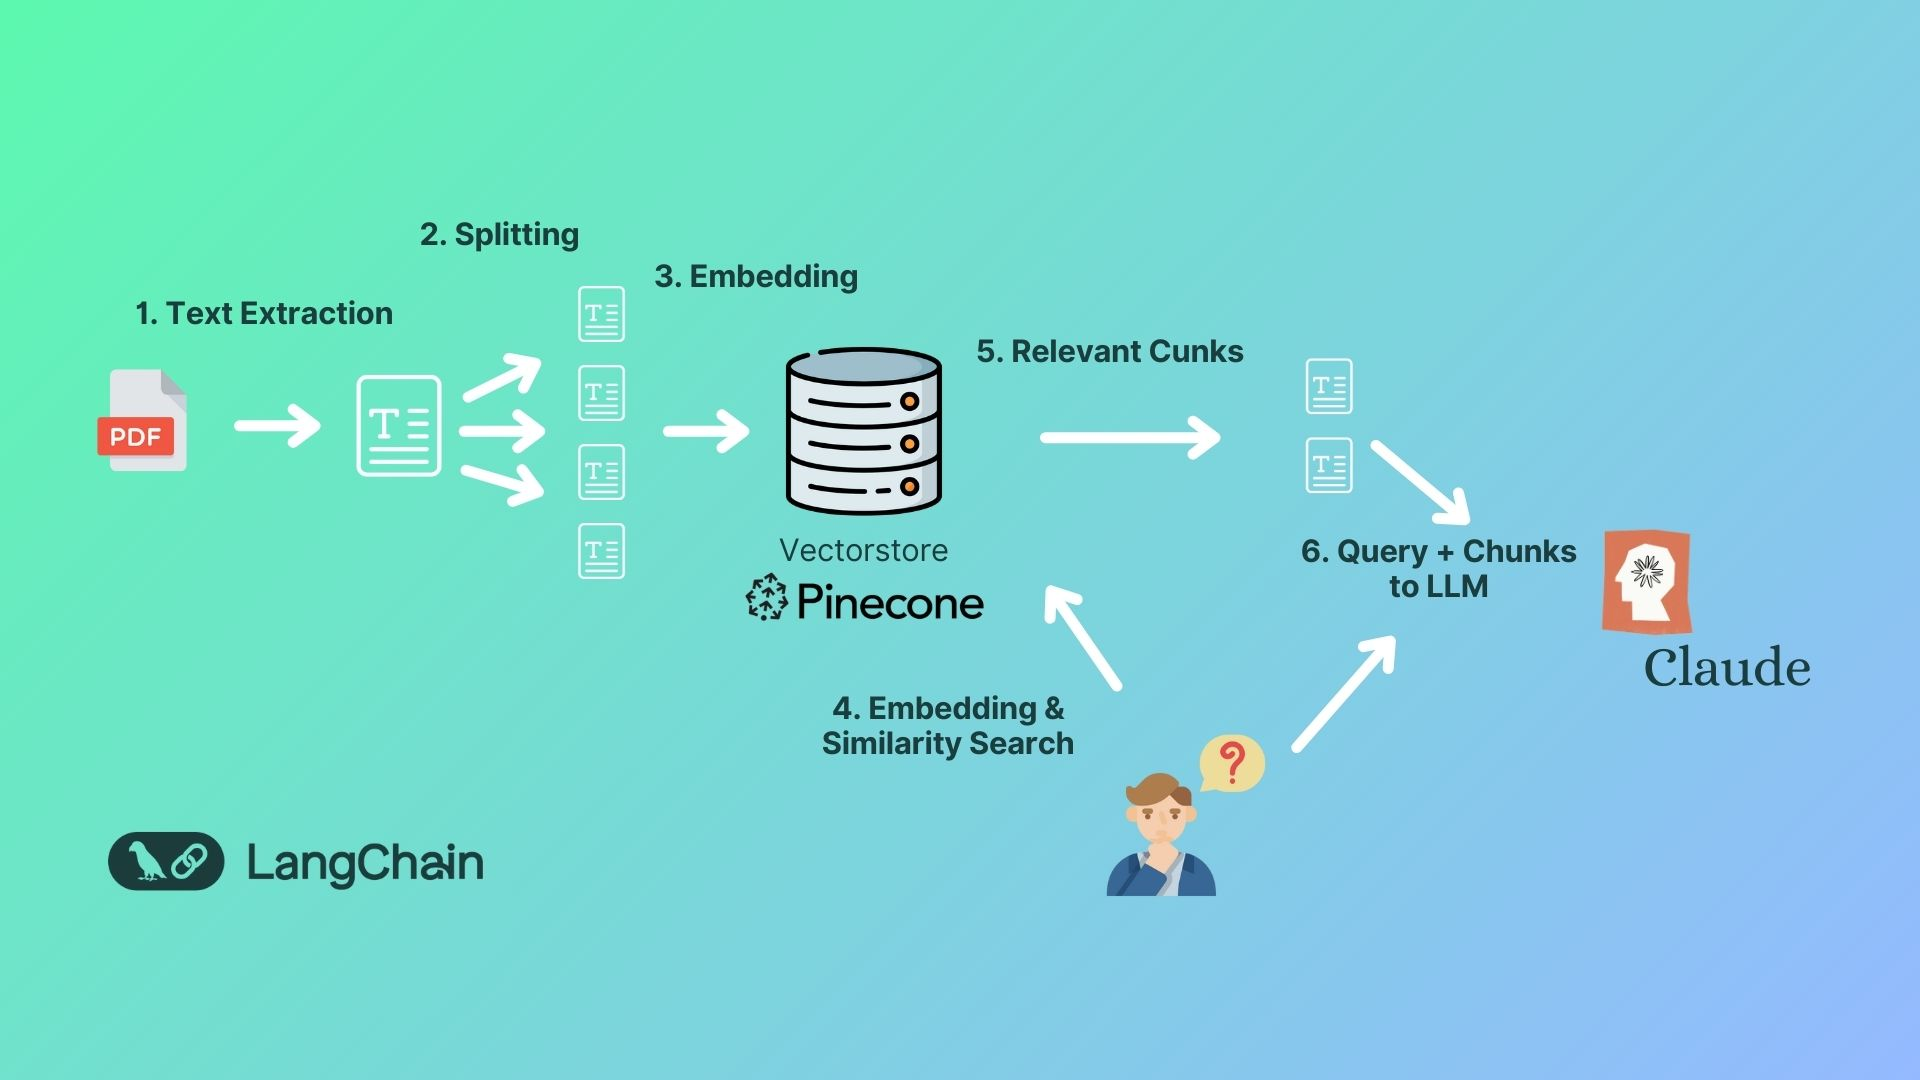

# 0. Install Dependencies

In [ ]:
!pip install langchain
!pip install langchain_community
!pip install langchain-pinecone
!pip install langchain-aws
!pip install unstructured
!pip install "unstructured[pdf]"
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 841.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.0/384.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 1,000.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Load PDFs

In [ ]:
from langchain.document_loaders import DirectoryLoader

loader = DirectoryLoader('/content/drive/MyDrive/Shared/YouTube/T072023_AIChatbot_Langchain_Pinecone_Claude/data', glob="**/*.pdf")
data = loader.load()

In [ ]:
data


[Document(metadata={'source': '/content/drive/MyDrive/Shared/YouTube/T072023_AIChatbot_Langchain_Pinecone_Claude/data/cancer_vaccines_Nature.pdf'}, page_content=': , ; ) ( 0 9 8 7 6 5 4 3 2 1\n\nSignal Transduction and Targeted Therapy\n\nwww.nature.com/sigtrans\n\nREVIEW ARTICLE Therapeutic cancer vaccines: advancements, challenges, and prospects Ting Fan 1, Mingna Zhang2, Jingxian Yang1, Zhounan Zhu1, Wanlu Cao1 ✉\n\nOPEN\n\nand Chunyan Dong1 ✉\n\nWith the development and regulatory approval of immune checkpoint inhibitors and adoptive cell therapies, cancer immunotherapy has undergone a profound transformation over the past decades. Recently, therapeutic cancer vaccines have shown promise by eliciting de novo T cell responses targeting tumor antigens, including tumor-associated antigens and tumor- speciﬁc antigens. The objective was to amplify and diversify the intrinsic repertoire of tumor-speciﬁc T cells. However, the complete realization of these capabilities remains an ongoing p

In [ ]:
print(f"You have {len(data)} documents")

You have 2 documents


In [ ]:
print(f"Document 1 contains {len(data[0].page_content)} characters")

Document 1 contains 159796 characters


# 2. Text Splitting

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)
chunks = text_splitter.split_documents(data)

In [ ]:
chunks

[Document(metadata={'source': '/content/drive/MyDrive/Shared/YouTube/T072023_AIChatbot_Langchain_Pinecone_Claude/data/cancer_vaccines_Nature.pdf'}, page_content=': , ; ) ( 0 9 8 7 6 5 4 3 2 1\n\nSignal Transduction and Targeted Therapy\n\nwww.nature.com/sigtrans\n\nREVIEW ARTICLE Therapeutic cancer vaccines: advancements, challenges, and prospects Ting Fan 1, Mingna Zhang2, Jingxian Yang1, Zhounan Zhu1, Wanlu Cao1 ✉\n\nOPEN\n\nand Chunyan Dong1 ✉\n\nWith the development and regulatory approval of immune checkpoint inhibitors and adoptive cell therapies, cancer immunotherapy has undergone a profound transformation over the past decades. Recently, therapeutic cancer vaccines have shown promise by eliciting de novo T cell responses targeting tumor antigens, including tumor-associated antigens and tumor- speciﬁc antigens. The objective was to amplify and diversify the intrinsic repertoire of tumor-speciﬁc T cells. However, the complete realization of these capabilities remains an ongoing p

In [ ]:
print(f"You have {len(chunks)} chunks")

You have 73 chunks


In [ ]:
print(f"The first chunk is {len(chunks[0].page_content)} characters long")

The first chunk is 3965 characters long


# 3. Vectorstore

In [ ]:
import boto3
from langchain_community.embeddings import BedrockEmbeddings
from langchain_pinecone import PineconeVectorStore

# Load embedding LLM
bedrock_client = boto3.client("bedrock-runtime",
                              region_name='us-east-1',
                              aws_access_key_id='',
                              aws_secret_access_key='')

bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrock_client)

# Load data to vectorstore
import os
os.environ['PINECONE_API_KEY'] = ""
PineconeVectorStore.from_documents(chunks, bedrock_embeddings, index_name='tutorial-202408')

ValueError: Error raised by inference endpoint: An error occurred (UnrecognizedClientException) when calling the InvokeModel operation: The security token included in the request is invalid.

# 4. Query Vectorstore

In [ ]:
vectorstore = PineconeVectorStore(index_name='tutorial-202408', embedding=bedrock_embeddings)

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_aws import ChatBedrock
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser

# Define prompt
template = '''You are a scientist in immunology.
Use this context to reply to the Question:
{context}

Question: {question}'''

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
# Load model
model = ChatBedrock(model_id='anthropic.claude-3-sonnet-20240229-v1:0', client=bedrock_client, model_kwargs={'temperature': 0}, region_name='us-east-1')

In [ ]:
# Function to merge text chunks
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# RAG chain
rag_chain = (
    {"context": vectorstore.as_retriever() | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
question = 'what is an antigen ?'
response = rag_chain.invoke(question)

In [ ]:
response

"An antigen is a substance that can trigger an immune response in the body by stimulating the production of antibodies or activating immune cells like T cells. Antigens can be foreign substances from pathogens (viruses, bacteria, etc.) or can originate from the body's own cells (self-antigens).\n\nIn the context of cancer immunology, there are two main types of antigens discussed:\n\n1. Tumor-associated antigens (TAAs) - These are self-antigens that are overexpressed in tumor cells compared to normal cells. Examples include cancer-testis antigens like MAGE that are normally only expressed in germ cells but get aberrantly expressed in some cancers.\n\n2. Tumor-specific antigens (TSAs) or neoantigens - These arise from mutations in the tumor cells that create novel protein sequences not present in normal cells. The mutant peptides can be presented by MHC molecules and recognized as foreign by T cells.\n\nHarnessing the immune system to recognize tumor antigens, especially the patient-spe